In [54]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# BlackJack simulator



### Planned steps

1. ~~Make the random function work (make sure the arguments inside local functions work properly)~~
2. ~~Basic Strategy engine~~
3. ~~Make the function appened to data frame~~
3. ~~bets - possible outcomes~~
4. analize the change of True count as the shoe progresses - how lon can a shoe be 'hot'?
5. ~~simulate whole card counting trips - assume bankroll and how it changes in time~~ 
3. implement "miss engine" - one that every one in a while misses the best move
1. ~~implement exceptions engine - to take into account true count into play. To be made possible with 3 dimensional numpy arrays~~
2. Kelly criterion analysis - optimize the bet size depending on True count and available bankroll
3. optimize the function


## Defining key functions

* shuffle - prepares a shoe of cards for function 'game_of_blackjack' to play
* game_of_blackjack - simulates a game of BlackJack using basic stretegy as players decision engine
* BJ_simulator - combines multiple games into a series, iterates over 'game_of_blackjack'


In [85]:
from blackjack_main_function import BJ_simulator

## Simulating 64,000 games
* 1000 iterations of shoes, each consisting 8 decks of cards and 8 games for every deck
* 100$ as the standard starting bet

In [86]:
data = BJ_simulator(iterations=10000, players_engine= 'basic')
data = pd.DataFrame(data)

KeyboardInterrupt: 

In [60]:
data.head(100)

,Starting cards,Dealers card,Hands amount,$result,Running count,True count,Cards left at start,Cards Left after the game
0,"[Club K, Diamond 10]",Heart Q,1.0,100.0,0.0,0.000000,416.0,410.0
1,"[Heart 2, Spade 5]",Heart 8,1.0,-100.0,-2.0,-0.253659,410.0,404.0
2,"[Spade A, Diamond 5]",Diamond K,1.0,-100.0,0.0,0.000000,404.0,398.0
3,"[Club Q, Club 4]",Spade 6,1.0,100.0,-1.0,-0.130653,398.0,393.0
4,"[Club 9, Club J]",Club 5,1.0,-100.0,-2.0,-0.264631,393.0,388.0
...,...,...,...,...,...,...,...,...
95,"[Spade 2, Diamond 4]",Diamond 9,1.0,100.0,-6.0,-1.248000,250.0,242.0
96,"[Spade 10, Diamond K]",Club 4,1.0,0.0,-2.0,-0.429752,242.0,236.0
97,"[Diamond 3, Diamond 2]",Heart 7,1.0,100.0,-1.0,-0.220339,236.0,230.0
98,"[Heart A, Heart 4]",Spade Q,1.0,100.0,0.0,0.000000,230.0,222.0


In [61]:
data.describe()

,Hands amount,$result,Running count,True count,Cards left at start,Cards Left after the game
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,1.028687,-0.230469,-0.147047,0.005897,238.580203,232.948297
std,0.191269,116.434508,7.638647,2.545720,104.245645,104.249326
min,1.000000,-600.000000,-38.000000,-16.383562,33.000000,29.000000
25%,1.000000,-100.000000,-5.000000,-1.171171,148.000000,143.000000
50%,1.000000,0.000000,0.000000,0.000000,239.000000,233.000000
75%,1.000000,100.000000,5.000000,1.133515,329.000000,323.000000
max,6.000000,600.000000,32.000000,18.416667,416.000000,412.000000


### counting cards basics
A key to counting cards in blackjack is keeping track of Running count (the amount of higher value cards left in the deck above expected) and adjusting it by dividing by the amount of cards left in a shoe. This result is called True count

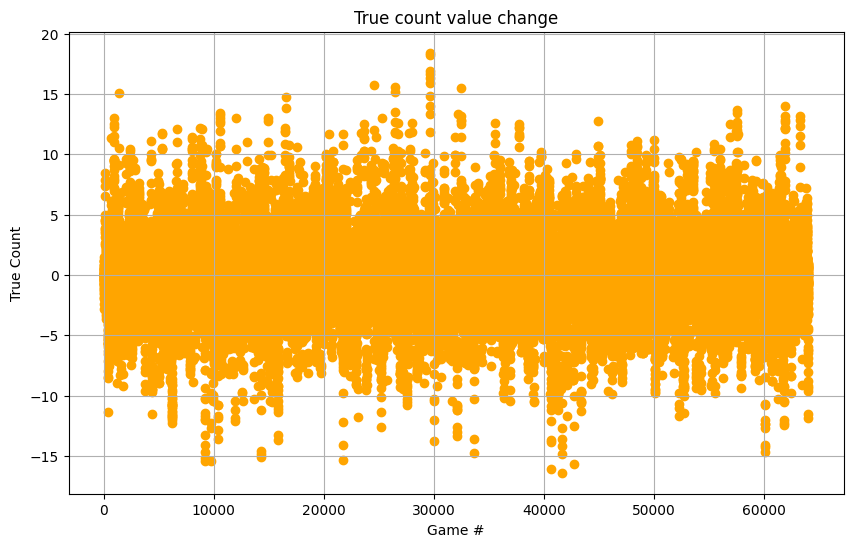

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data['True count'], color='orange')
plt.title('True count value change')
plt.xlabel('Game #')
plt.ylabel('True Count')
plt.grid(True)
plt.show()


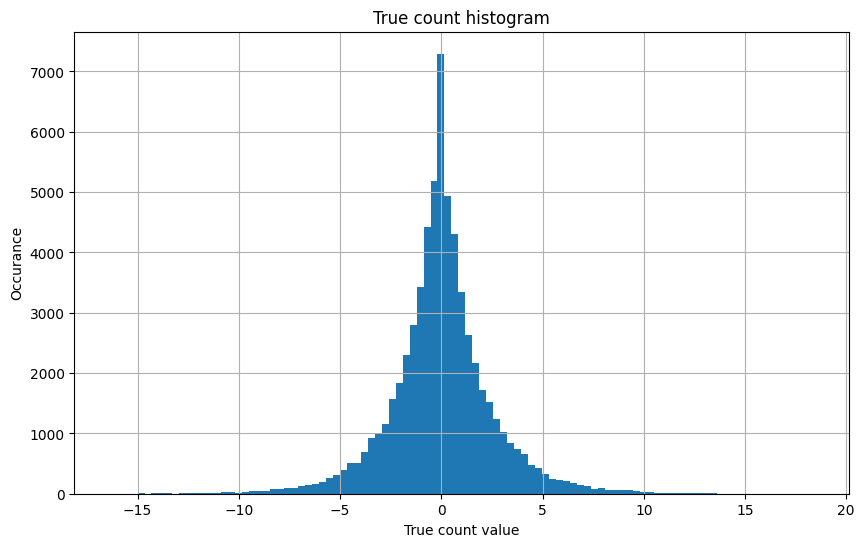

In [65]:
plt.figure(figsize=(10, 6))
data['True count'].hist(bins=101)
plt.title('True count histogram')
plt.xlabel('True count value')
plt.ylabel('Occurance')
plt.show()

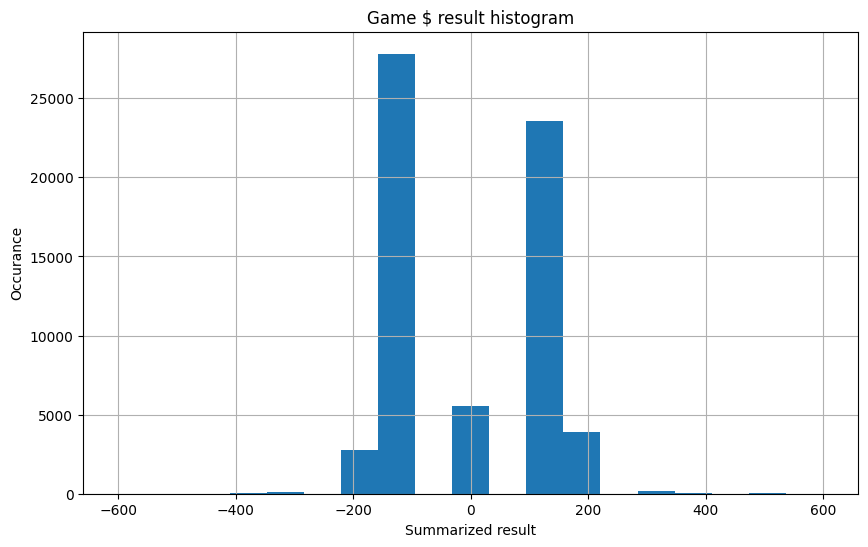

In [66]:
plt.figure(figsize=(10, 6))
data['$result'].hist(bins=19)
plt.title('Game $ result histogram')
plt.xlabel('Summarized result')
plt.ylabel('Occurance')
plt.show()

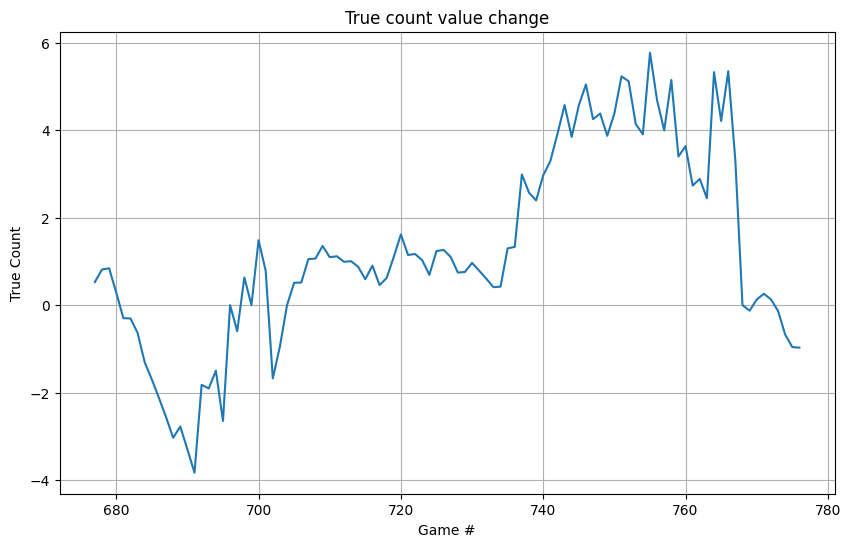

In [82]:
plt.figure(figsize=(10, 6))
r = random.randint(0, 15899)
d = data.iloc[r:(r+100)]
plt.plot(d.index, d['True count'])
plt.title('True count value change')
plt.xlabel('Game #')
plt.ylabel('True Count')
plt.grid(True)
plt.show()


## How good of a predictor is the value of True Count?
In general pretty weak - most books assume 0.5% of edge for the player more for every unit of TC

Lets run a Linear Regression model and Logistic Regression model to find out how strong it the predictiveness of TC

MSE:  13579.351114366415
R^2:  -6.197976889210643e-05


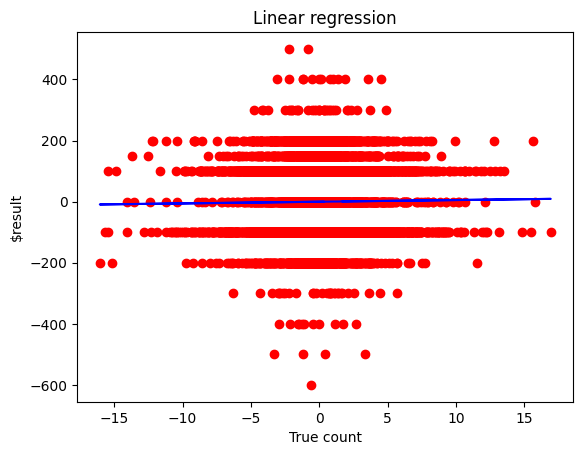

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = data[['True count']]
Y = data['$result']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)



model = LinearRegression()


model.fit(X_train, Y_train)



Y_pred = model.predict(X_test)


mse = mean_squared_error(Y_test, Y_pred)
print("MSE: ", mse)


r2_score = model.score(X_test, Y_test)
print("R^2: ", r2_score)


plt.scatter(X_test, Y_test, color='red')
plt.plot(X_test, Y_pred, color='blue')
plt.title('Linear regression')
plt.xlabel('True count')
plt.ylabel('$result')
plt.show()


Accuracy:  0.52140625
Confusion matrix: 
 [[  75 6051]
 [  75 6599]]


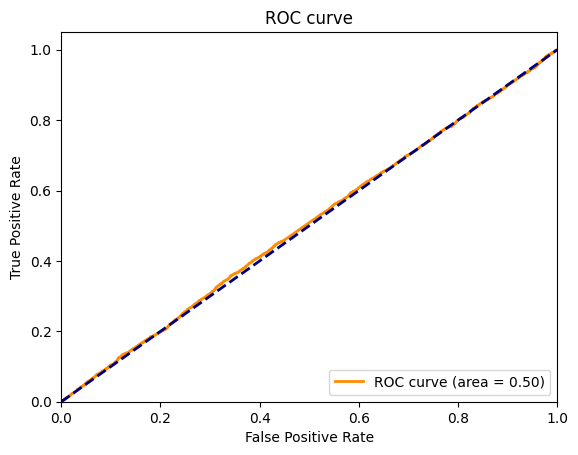

In [84]:
data1= data
data1['win'] = data1['$result'].apply(lambda x: 1 if x >= 0 else 0)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix



X = data1[['True count']]
Y = data1['win']           


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


model = LogisticRegression()


model.fit(X_train, Y_train)


Y_pred = model.predict(X_test)


accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

print("Accuracy: ", accuracy)
print("Confusion matrix: \n", conf_matrix)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


Y_pred_proba = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


# Implement True Count into the strategy and make simulations of whole card counting trips

True Count has 2 important applications - it allows to adjust the bet depending on the probability of win and allows to deviete form Basic Stretegy when it starts to be beneficial to the player

In below scenario we used a simplified Kelly Criterion to choose the optimal bet. It is optimized better than usually card counters do, because it is a descrete number in our example, wheres in most cases players would fix the strategy for each day of counting (not chenging the startegy between hands)

Additionally we use the numpy arrays from game_of_blackjack to deviate from Basic Strategy when it is more optimal for the player

In [15]:
def BJ_simulation_wrapper(trips: int, starting_bankroll:int, min_table_bet: int, games_per_trip:int, max_table_bet: int = 10000, shoe_size=8, games_per_deck=8):
    df = pd.DataFrame({'Starting cards': [], 'Dealers card': [], 'Hands amount': [], '$result': [], 'Running count': [],'True count':[], 'Cards left at start': [], 'Cards Left after the game':[], 'Series id': []})
    for i in range(trips):
        bankroll = starting_bankroll - df[df['Series id'] == i]['$result'].sum()
        bankroll = float(bankroll)
        data = BJ_simulator(iterations=games_per_trip, bankroll=bankroll, shoe_size=8, bet_size=100, games_per_deck=7, min_table_bet=min_table_bet, max_table_bet = max_table_bet, players_engine = 'deviation')
        data['Series id'] = i
        data['Game number'] = range(1, len(data) + 1)
        df = pd.concat([df, data], ignore_index=True, axis=0)

    df['Money left'] = df.groupby('Series id')['$result'].cumsum() + starting_bankroll
    df['Ruin'] = df['Money left'] <= 0
    df['Ruin game'] = np.where(df['Ruin'], df['Game number'], np.nan)

    metadata = pd.pivot_table(df, values=['$result', 'Money left', 'Ruin game'],
                              index=['Series id'],
                              aggfunc={
                                  '$result': 'sum',
                                  'Money left': 'last',
                                  'Ruin game': lambda x: np.nan if x.isnull().all() else np.nanmin(x)
                              })

    metadata.rename(columns={'$result': 'trip $ result', 'Money left': 'money left'}, inplace=True)
    
    metadata.reset_index(inplace=True)
    metadata['average hand value'] = metadata['trip $ result'] / games_per_trip

    metadata['series length'] = games_per_trip*games_per_deck*shoe_size
    metadata.rename(columns={'Ruin game': 'ruin game'}, inplace=True)
    metadata['ruin'] = np.where(pd.isna(metadata['ruin game']), 0, 1)
    metadata.drop(columns=['Series id'], inplace=True)
    metadata['starting bankroll'] = starting_bankroll

    columns = list(metadata.columns)
    columns.insert(0, columns.pop(columns.index('starting bankroll')))
    metadata = metadata[columns]

    return metadata, df




In [16]:
metadata, df = BJ_simulation_wrapper(trips = 100, starting_bankroll = 10000, min_table_bet = 100, games_per_trip=100)
metadata

,starting bankroll,trip $ result,money left,ruin game,average hand value,series length,ruin
0,10000,-10922.523899,-922.523899,2182.0,-109.225239,6400,1
1,10000,-7202.052373,2797.947627,1611.0,-72.020524,6400,1
2,10000,-26199.409883,-16199.409883,1175.0,-261.994099,6400,1
3,10000,10545.228720,20545.228720,NaN,105.452287,6400,0
4,10000,-25615.354862,-15615.354862,1268.0,-256.153549,6400,1
...,...,...,...,...,...,...,...
95,10000,3619.395978,13619.395978,1083.0,36.193960,6400,1
96,10000,7347.775266,17347.775266,2238.0,73.477753,6400,1
97,10000,13893.981509,23893.981509,NaN,138.939815,6400,0
98,10000,-21018.845248,-11018.845248,1041.0,-210.188452,6400,1


In [17]:
metadata.describe()

,starting bankroll,trip $ result,money left,ruin game,average hand value,series length,ruin
count,100.0,100.000000,100.000000,56.000000,100.000000,100.0,100.000000
mean,10000.0,-5634.905879,4365.094121,2425.964286,-56.349059,6400.0,0.560000
std,0.0,14151.039278,14151.039278,1300.489753,141.510393,0.0,0.498888
min,10000.0,-47290.113823,-37290.113823,468.000000,-472.901138,6400.0,0.000000
25%,10000.0,-13597.952946,-3597.952946,1446.500000,-135.979529,6400.0,0.000000
50%,10000.0,-5560.622168,4439.377832,2210.000000,-55.606222,6400.0,1.000000
75%,10000.0,4087.789627,14087.789627,3180.750000,40.877896,6400.0,1.000000
max,10000.0,22020.349878,32020.349878,5542.000000,220.203499,6400.0,1.000000


In [18]:
df

,Starting cards,Dealers card,Hands amount,$result,Running count,True count,Cards left at start,Cards Left after the game,Series id,Game number,Money left,Ruin,Ruin game
0,"[Spade 3, Spade 4]",Heart Q,1.0,0.000000,0.0,0.000000,416.0,410.0,0.0,1.0,10000.000000,False,NaN
1,"[Club A, Spade 9]",Heart 8,1.0,100.000000,1.0,0.126829,410.0,406.0,0.0,2.0,10100.000000,False,NaN
2,"[Club 9, Diamond J]",Club A,1.0,-100.000000,0.0,0.000000,406.0,399.0,0.0,3.0,10000.000000,False,NaN
3,"[Spade A, Club 10]",Diamond 8,1.0,150.000000,0.0,0.000000,399.0,393.0,0.0,4.0,10150.000000,False,NaN
4,"[Heart 7, Heart 3]",Diamond 10,1.0,-100.000000,-2.0,-0.264631,393.0,388.0,0.0,5.0,10050.000000,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559995,"[Heart 3, Spade 10]",Diamond 8,1.0,-100.000000,4.0,1.650794,126.0,119.0,99.0,5596.0,-3484.117149,True,5596.0
559996,"[Heart A, Diamond 9]",Spade 10,1.0,161.815126,6.0,2.621849,119.0,115.0,99.0,5597.0,-3322.302023,True,5597.0
559997,"[Diamond J, Heart 8]",Diamond 2,1.0,0.000000,4.0,1.808696,115.0,110.0,99.0,5598.0,-3322.302023,True,5598.0
559998,"[Spade A, Club 2]",Heart A,1.0,-100.000000,4.0,1.890909,110.0,103.0,99.0,5599.0,-3422.302023,True,5599.0


In [19]:
df.describe()

,Hands amount,$result,Running count,True count,Cards left at start,Cards Left after the game,Series id,Game number,Money left,Ruin game
count,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,560000.000000,111926.000000
mean,1.031389,-1.006233,-0.083450,0.002422,260.265111,254.599848,49.500000,2800.500000,7179.807364,3793.486545
std,0.230861,181.154308,7.688948,2.077712,91.722507,91.732521,28.866096,1616.582171,10227.751863,1155.535745
min,1.000000,-26789.853659,-42.000000,-14.687023,33.000000,26.000000,0.000000,1.000000,-41311.045513,468.000000
25%,1.000000,-100.000000,-5.000000,-0.997260,181.000000,175.000000,24.750000,1400.750000,1820.623982,2934.000000
50%,1.000000,0.000000,0.000000,0.000000,260.000000,255.000000,49.500000,2800.500000,7969.310936,3922.000000
75%,1.000000,100.000000,5.000000,0.977444,340.000000,334.000000,74.250000,4200.250000,12868.527593,4743.000000
max,31.000000,21116.363636,40.000000,15.826087,416.000000,412.000000,99.000000,5600.000000,38765.886859,5600.000000


In [22]:
#df.to_csv('sim results.csv', index=False)

In [23]:
#metadata.to_csv('meta results.csv', index=False)